In [1]:
import pandas as pd
pd.__version__
# import os
# os.path.abspath(pd.__file__)

'0.22.0'

In [2]:
%matplotlib inline
from sklearn import datasets, linear_model
import numpy as np
import matplotlib.pyplot as plt
# Set plot font to Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['font.size'] = 16

### String Constants

In [3]:
df_suffix = 'Df.pkl'
byTrial_suffix = 'DfByTrial.pkl'
overall_suffix = 'OverallStatsDf.pkl'
summary_suffix = 'SummaryText.txt'
date_prefix = '180114'
date_prefix_normal = '180426'
outdir_prefix = 'graphs/'
outdir_prefix_std_error = 'graphsWithStandardErrorBars/'

BINARY = "B"
NORMAL = "N"

BANDIT = "Bandit Sampling"
PRIOR_BTW = "Prior between"
PRIOR_BELOW = "Prior below"
PRIOR_ABOVE = "Prior above"
UNIFORM = "Uniform Sampling"
mean_names_lst = (PRIOR_BTW, PRIOR_BELOW, PRIOR_ABOVE, UNIFORM)
std_names_lst = (PRIOR_BTW + " std", PRIOR_BELOW + " std", PRIOR_ABOVE + " std", UNIFORM + " std")

bb_prefix = "bb"
bb_infix = "BB"
bu_prefix = "bbUniform"
bu_infix = "BU"
bb_prior_below_prefix = "bbHighArms"
bb_prior_above_prefix = "bbLowArms"
b_prefix_lst = (bb_prefix, bb_prior_below_prefix, bb_prior_above_prefix, bu_prefix)
b_infix_lst = (bb_infix, bb_infix, bb_infix, bu_infix)

ng_prefix = "ng"
ng_infix = "NG"
nu_prefix = "ngUniform"
nu_infix = "NU"
ng_prior_below_prefix = "ngHighArms"
ng_prior_above_prefix = "ngLowArms"
n_prefix_lst = (ng_prefix, ng_prior_below_prefix, ng_prior_above_prefix, nu_prefix)
n_infix_lst = (ng_infix, ng_infix, ng_infix, nu_infix)

# (Optimal, Prior Btw, Prior below, Prior above, Uniform)
colors = ('#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99')
# (Optimal, Prior Btw, Prior Btw Regression, Uniform, Uniform Regression)
colors_line = ('#a6cee3','#1f78b4','#fc8d62','#fb9a99','#018571')

colors_line_reward = ('#6c7cd1','#1f78b4','#fc6284','#fb9a99','#1d4615')

### Simulation Settings

In [4]:
effectSizeB = (0.1, 0.3, 0.5)
effectSizeN = (0.2, 0.5, 0.8)

In [5]:
effectSize_label = ("Small", "Moderate", "Large")

# Average Reward Gain per Step

In [6]:
# Acutal rewards
bb_01_arms = (0.55, 0.45)
bb_03_arms = (0.65, 0.35)
bb_05_arms = (0.75, 0.25)

ng_prior_btw = (0.5, -0.5)
ng_prior_below = (1.0, 0.5)
ng_prior_above = (-0.5, -1.0)
ng_uniform = (0.5, -0.5)
ng_reward_dict = {PRIOR_BTW:ng_prior_btw, PRIOR_BELOW:ng_prior_below, PRIOR_ABOVE:ng_prior_above, UNIFORM:ng_uniform}

In [7]:
def scale_normal_rewards(x, good_arm, bad_arm):
    return ((x - (bad_arm)) / (good_arm - (bad_arm)))

In [8]:
def get_avg_col_per_num_steps_dfs(effect_size, reward_type, col, stdError=False):
    df_lst = []
    effect_size = str(effect_size)
    if reward_type == BINARY:
        prefix_lst = b_prefix_lst
        infix_lst = b_infix_lst
    elif reward_type == NORMAL:
        prefix_lst = n_prefix_lst
        infix_lst = n_infix_lst
    
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+effect_size+infix+effect_size+df_suffix)
        df_lst.append(df)
        
    avg_lst = []
    std_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['num_steps', col]].groupby('num_steps')
        
        avg = gp.mean().reset_index().rename(columns={col: mean_names_lst[i]})
        avg_lst.append(avg)
        std = gp.std().reset_index().rename(columns={col: std_names_lst[i]})
        if (stdError):
            count = gp.size().reset_index(name='counts')
            std[std_names_lst[i]] = std[std_names_lst[i]] / np.sqrt(count['counts'])
            
        std_lst.append(std)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['num_steps'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['num_steps'])
    for i in range(len(std_lst)):
        result = pd.merge(result, std_lst[i], how='outer', on=['num_steps'])
        
    result = result.reset_index(drop=True).set_index('num_steps')

    return result

In [9]:
def get_avg_col_per_step_dfs(effect_size, reward_type, col, stdError=False):
    avg_total_rewards = get_avg_col_per_num_steps_dfs(effect_size, reward_type, col, stdError)
    for column in avg_total_rewards.columns:
        # Update mean and std
        avg_total_rewards[column] = avg_total_rewards[column] / avg_total_rewards.index

        # Apply scaling if normal rewards
        if col == "total_reward" and reward_type == NORMAL:
            if "std" not in column:
                # scale avg
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(scale_normal_rewards, args=(max(ng_reward_dict[column]), min(ng_reward_dict[column])))
            else: 
                # scale std
                avg_total_rewards[column] = avg_total_rewards[column].\
                apply(lambda x: x / (max(ng_reward_dict[column[:-4]]) - min(ng_reward_dict[column[:-4]])))

    return avg_total_rewards

### Get Better arm (2 arms)

In [10]:
import ast
def get_better_arm(effect_size, reward_type):
    effect_size = str(effect_size)
    if reward_type == BINARY:
        summary = open("bb"+effect_size+"BB"+effect_size+summary_suffix)
    elif reward_type == NORMAL:
        return 1

    for line in summary:
        if line.startswith("Arm stats:"):
            arms = line.split(':')[1].strip()
            return max(ast.literal_eval(arms)[:2])

## Line Plot

In [11]:
def subplot_line(df, effect_size, rewards_type, ax, setLegend, title, legend_anchor=(1, 1.65),\
                ylabel="", hline_value=None, hline_label=None, setLinearRegression=True, color=None):
    
    legend = []
    
    i = 0
    if hline_value!=None:
        if color == None:
            ax.axhline(hline_value, linestyle='dashed', linewidth=2)
        else:
            ax.axhline(hline_value, linestyle='dashed', linewidth=2, color=color[i])
            i += 1
        legend.append(hline_label)

    for col in df.columns.values:       
        x = df.index.values.reshape(len(df.index.values), 1)
        y = df[col].values
        
        if color == None:
            plt.plot(x, y)
        else:
            plt.plot(x, y, color=color[i])
            i+=1
       
        legend.append(col)
        if setLinearRegression:
            regr = linear_model.LinearRegression()
            regr.fit(x, y)
            
            if color == None:
                plt.plot(x, regr.predict(x), linewidth=2)
            else:
                plt.plot(x, regr.predict(x), linewidth=2, color=color[i])
                i += 1

            legend.append(col+" regression")
    plt.xlabel("Sample size")
    ax.set_ylabel(ylabel)
    legend[len(legend) - 1] = 'Uniform assignment regression'
    legend[len(legend) - 2] = 'Uniform assignment'

    plt.title(title)

    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)

# Average Reward Gain at each Step

In [12]:
def get_avg_col_per_trial_dfsByTrial(es, reward_type, col, includeBelowAbove):
    df_lst = []
    effect_size = str(es)
    if reward_type == BINARY:
        prefix_lst = b_prefix_lst
        infix_lst = b_infix_lst
    elif reward_type == NORMAL:
        prefix_lst = n_prefix_lst
        infix_lst = n_infix_lst
    
    columns = list(mean_names_lst)
    if not includeBelowAbove:
        prefix_lst = [prefix_lst[0], prefix_lst[-1]]
        infix_lst = [infix_lst[0], infix_lst[-1]]
        columns = [columns[0], columns[-1]]
    
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+effect_size+infix+effect_size+byTrial_suffix)
        df_lst.append(df)
        
    avg_lst = []
    for i in range(len(df_lst)):
        df = df_lst[i]
        
        gp = df[['trial', col]].groupby('trial')
        
        avg = gp.mean().reset_index().rename(columns={col: columns[i]})

        for j in range(len(avg['trial'])-1):
            avg.loc[j,columns[i]] = avg.loc[j+1,columns[i]] - avg.loc[j,columns[i]]
            
        if col == "total_reward" and reward_type == NORMAL:
            avg[columns[i]] = avg[columns[i]].\
            apply(scale_normal_rewards, \
                  args=(max(ng_reward_dict[columns[i]]), min(ng_reward_dict[columns[i]])))

        avg_lst.append(avg)

    result = pd.merge(avg_lst[0], avg_lst[1], how='outer', on=['trial'])
    for i in range(2, len(avg_lst)):
        result = pd.merge(result, avg_lst[i], how='outer', on=['trial'])
   
    result = result.reset_index(drop=True).set_index('trial')
    
    return result.iloc[:-1]

In [13]:
def plot_avg_reward_gain_at_m(reward_type, legend_anchor=(1, 1.35), stdError=False):
    df = pd.DataFrame(dtype=float)
    if reward_type == BINARY:
        effectSize = effectSizeB
    elif reward_type == NORMAL:
        effectSize = effectSizeN
    for i in range(len(effectSize)):
        es = effectSize[i]
        df_m = get_avg_col_per_step_dfs(es, reward_type, "total_reward", stdError=stdError).iloc[1:2]
        df_m["effect_size"] = es
        df_m["Optimal Reward"] = get_better_arm(effectSize[i], reward_type)
        df_m["or_std"] = pd.Series()

        df = pd.concat([df, df_m])
    df = df.reset_index().set_index('effect_size')
    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    ax = m.plot.bar(yerr=std, rot=0, color=colors)

    ax.set_xlabel('')
    xticks = []
    for i in range(len(df.index.values)):
        xticks.append("Effect size="+str(df.index.values[i])+",\n num_steps="+str(df['num_steps'].values[i]))
    ax.set_xticklabels(xticks)
    ax.set_ylabel("Rewards")
    
    ax.legend(ncol=5, bbox_to_anchor=legend_anchor)

    if reward_type == BINARY:
        ax.set_title("Average Reward Gain per Step in m Steps (Binary Reward)")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward Gain per Step in m Steps (Scaled, Normal Reward)")
    return ax

### Binary Rewards

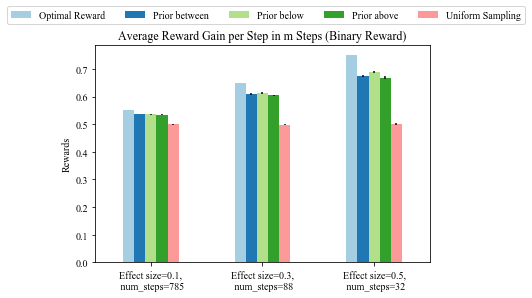

In [89]:
ax = plot_avg_reward_gain_at_m(BINARY, legend_anchor=(1.3, 1.2), stdError=True)

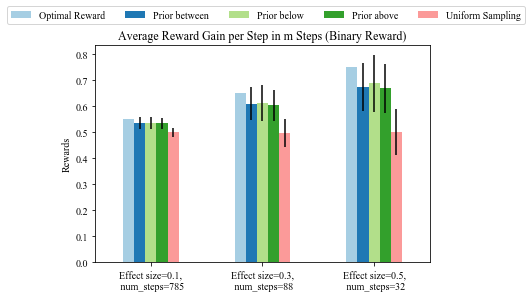

In [90]:
ax = plot_avg_reward_gain_at_m(BINARY, legend_anchor=(1.3, 1.2), stdError=False)

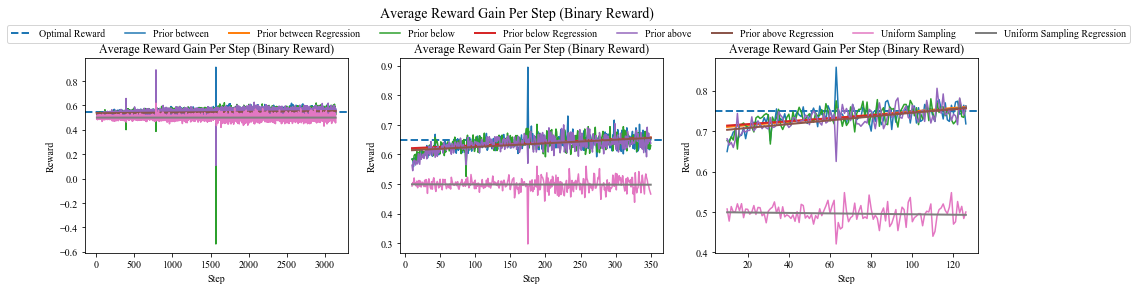

In [15]:
figure = plt.figure(figsize = (16, 4))
setLegend = True

# Plot subgraphs
axes = []
for i in range(len(effectSizeB)):
    ax = figure.add_subplot(1, len(effectSizeB), i + 1)
    axes.append(ax)

    avg_rewards_per_trial_binary = get_avg_col_per_trial_dfsByTrial(effectSizeB[i], BINARY, "total_reward", True)
    subplot_line(avg_rewards_per_trial_binary, effectSizeB[i], "Binary", ax, setLegend, "Average Reward Gain Per Step (Binary Reward)", \
                ylabel="Reward", legend_anchor=(4, 1.2), hline_value=get_better_arm(effectSizeB[i], BINARY), hline_label="Optimal Reward")
    setLegend = False

# Set super title for all subgraphs
figure.suptitle("Average Reward Gain Per Step (Binary Reward)",  fontsize=14)
plt.subplots_adjust(top=0.8)

### Normal Rewards

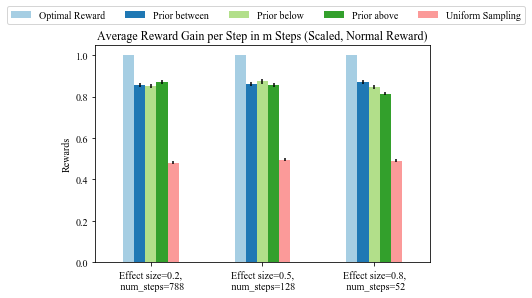

In [79]:
ax = plot_avg_reward_gain_at_m(NORMAL, legend_anchor=(1.3, 1.2), stdError=True)

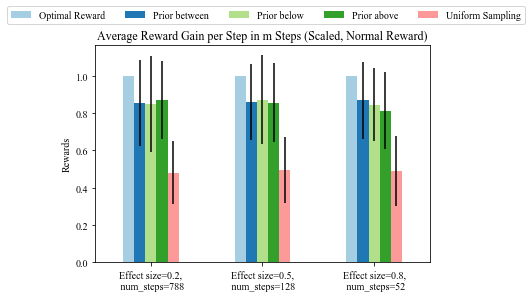

In [80]:
ax = plot_avg_reward_gain_at_m(NORMAL, legend_anchor=(1.3, 1.2), stdError=False)

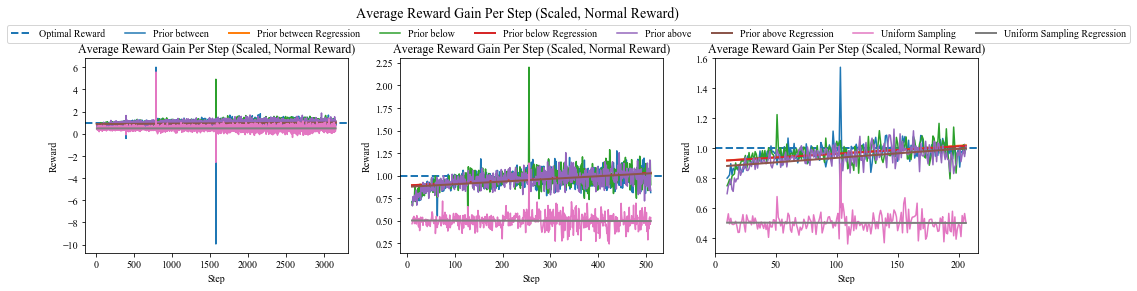

In [17]:
figure = plt.figure(figsize = (16, 4))
setLegend = True

# Plot subgraphs
axes = []
for i in range(len(effectSizeN)):
    ax = figure.add_subplot(1, len(effectSizeN), i + 1)
    axes.append(ax)

    avg_rewards_per_trial_normal = get_avg_col_per_trial_dfsByTrial(effectSizeN[i], NORMAL, "total_reward", True)
    subplot_line(avg_rewards_per_trial_normal, effectSizeN[i], "Normal", ax, setLegend, "Average Reward Gain Per Step (Scaled, Normal Reward)", \
                ylabel="Reward", legend_anchor=(4, 1.2), hline_value=get_better_arm(effectSizeN[i], NORMAL), hline_label="Optimal Reward")
    setLegend = False

# Set super title for all subgraphs
figure.suptitle("Average Reward Gain Per Step (Scaled, Normal Reward)",  fontsize=14)
plt.subplots_adjust(top=0.8)

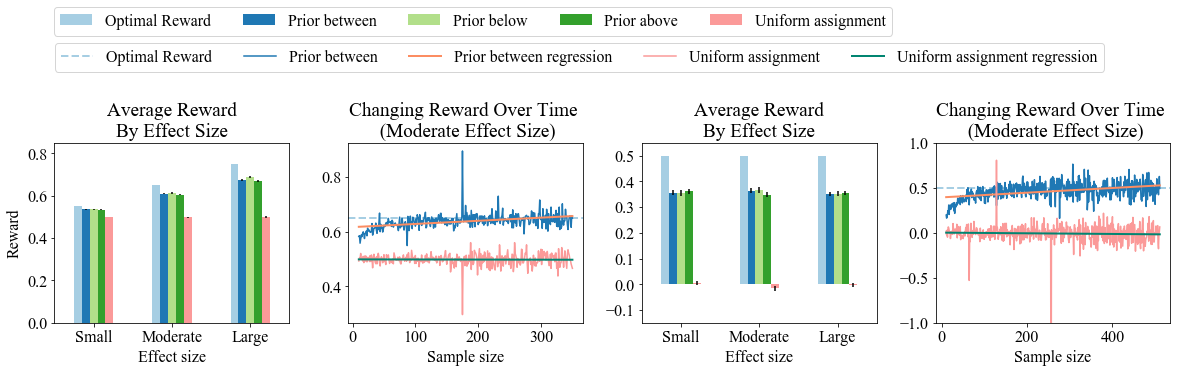

In [11]:
figure = plt.figure(figsize = (20, 4))
legend_height = 1.8
stdError = True
# Bar for Binary Reward 
ax = figure.add_subplot(1, 4, 1)
plot_avg_reward_gain_at_m(BINARY, ax, ylabel="Reward", legend_anchor=(3.6, legend_height), stdError=stdError)
ax.set_ylim(0, .85)

# Line for Binary Reward 
mid_es_B = effectSizeB[len(effectSizeB) // 2]
ax = figure.add_subplot(1, 4, 2)
# avg_rewards_per_trial_binary = get_avg_col_per_trial_dfsByTrial(mid_es_B, BINARY, "total_reward", False)
# import pickle
# with open(date_prefix+'AvgRewardsPerTrialBinary.pkl', 'wb') as f:
#     pickle.dump(avg_rewards_per_trial_binary, f)
avg_rewards_per_trial_binary = pd.read_pickle(date_prefix+'AvgRewardsPerTrialBinary.pkl')

subplot_line(avg_rewards_per_trial_binary, mid_es_B, "Binary", ax, False, "Changing Reward Over Time \n (Moderate Effect Size)", \
            hline_value=.65, hline_label="Optimal Reward", color=colors_line)

# Bar for Normal Reward 
ax = figure.add_subplot(1, 4, 3)
plot_avg_reward_gain_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)
ax.set_ylim(-.15, .55)
ax.set_yticks([-.1,0,.1,.2,.3,.4,.5])
# Line for Normal Reward 
mid_es_N = effectSizeN[len(effectSizeN) // 2]
ax = figure.add_subplot(1, 4, 4)
# avg_rewards_per_trial_normal = get_avg_col_per_trial_dfsByTrial(mid_es_N, NORMAL, "total_reward", False)
# import pickle
# with open(date_prefix+'AvgRewardsPerTrialNormal.pkl', 'wb') as f:
#     pickle.dump(avg_rewards_per_trial_normal, f)
avg_rewards_per_trial_normal = pd.read_pickle(date_prefix_normal+'AvgRewardsPerTrialNormal.pkl')

subplot_line(avg_rewards_per_trial_normal, mid_es_N, "Normal", ax, True, title="Changing Reward Over Time \n (Moderate Effect Size)", \
            legend_anchor=(.75, legend_height - .2), hline_value=0.5, hline_label="Optimal Reward", color=colors_line)
ax.set_ylim(-1,1)
# Set super title for all subgraphs
plt.subplots_adjust(top=.75)
plt.subplots_adjust(wspace=.25)
if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
figure.savefig(outdir+date_prefix+'AvgRewardGainPerStep.pdf', bbox_inches='tight')

graphsWithStandardErrorBars/190617AvgRewardGainPerStep.pdf


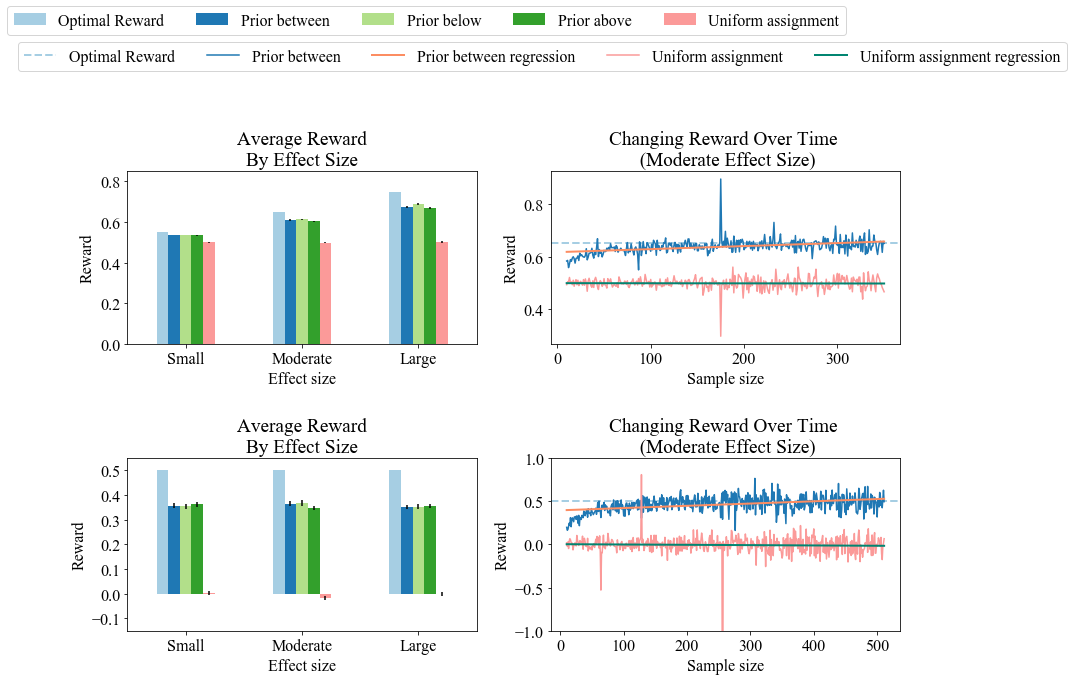

In [41]:
# figure = plt.figure(figsize = (20, 4))
figure = plt.figure(figsize = (12, 8))

legend_height = 1.8
stdError = True
# Bar for Binary Reward 
# ax = figure.add_subplot(1, 4, 1)
ax = figure.add_subplot(2, 2, 1)

plot_avg_reward_gain_at_m(BINARY, ax, ylabel="Reward", legend_anchor=(2.08, legend_height+.2), stdError=stdError)
ax.set_ylim(0, .85)

# Line for Binary Reward 
mid_es_B = effectSizeB[len(effectSizeB) // 2]
# ax = figure.add_subplot(1, 4, 2)
ax = figure.add_subplot(2, 2, 2)

# avg_rewards_per_trial_binary = get_avg_col_per_trial_dfsByTrial(mid_es_B, BINARY, "total_reward", False)
# import pickle
# with open(date_prefix+'AvgRewardsPerTrialBinary.pkl', 'wb') as f:
#     pickle.dump(avg_rewards_per_trial_binary, f)
avg_rewards_per_trial_binary = pd.read_pickle(date_prefix+'AvgRewardsPerTrialBinary.pkl')

subplot_line(avg_rewards_per_trial_binary, mid_es_B, "Binary", ax, False, "Changing Reward Over Time \n (Moderate Effect Size)", \
            hline_value=.65, hline_label="Optimal Reward", color=colors_line, ylabel="Reward")

# Bar for Normal Reward 
# ax = figure.add_subplot(1, 4, 3)
ax = figure.add_subplot(2, 2, 3)

plot_avg_reward_gain_at_m(NORMAL, ax, ylabel="Reward", hasLegend=False, stdError=stdError)
ax.set_ylim(-.15, .55)
ax.set_yticks([-.1,0,.1,.2,.3,.4,.5])
# Line for Normal Reward 
mid_es_N = effectSizeN[len(effectSizeN) // 2]
# ax = figure.add_subplot(1, 4, 4)
ax = figure.add_subplot(2, 2, 4)

# avg_rewards_per_trial_normal = get_avg_col_per_trial_dfsByTrial(mid_es_N, NORMAL, "total_reward", False)
# import pickle
# with open(date_prefix+'AvgRewardsPerTrialNormal.pkl', 'wb') as f:
#     pickle.dump(avg_rewards_per_trial_normal, f)
avg_rewards_per_trial_normal = pd.read_pickle(date_prefix_normal+'AvgRewardsPerTrialNormal.pkl')

subplot_line(avg_rewards_per_trial_normal, mid_es_N, "Normal", ax, True, title="Changing Reward Over Time \n (Moderate Effect Size)", \
            legend_anchor=(1.5, 3.45), hline_value=0.5, hline_label="Optimal Reward", color=colors_line, ylabel="Reward")
ax.set_ylim(-1,1)
# Set super title for all subgraphs
# plt.subplots_adjust(top=.75)
# plt.subplots_adjust(wspace=.25)
figure.tight_layout(h_pad=2)

if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
save_date_prefix = "190617"
figure.savefig(outdir+save_date_prefix+'AvgRewardGainPerStep.pdf', bbox_inches='tight')
print(outdir+save_date_prefix+'AvgRewardGainPerStep.pdf')

x_col ['x_spacing']
y   Prior between Prior below Prior above Uniform Sampling
0         0.548        0.52        0.53            0.808
1         0.484       0.418       0.566            0.732
2         0.508       0.552       0.616            0.796
3         0.742       0.702       0.724            0.976
4         0.646        0.64       0.778            0.982
5         0.672       0.698        0.82            0.974
graphsWithStandardErrorBars/180114AvgPowerAndRewardsNormal.pdf


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


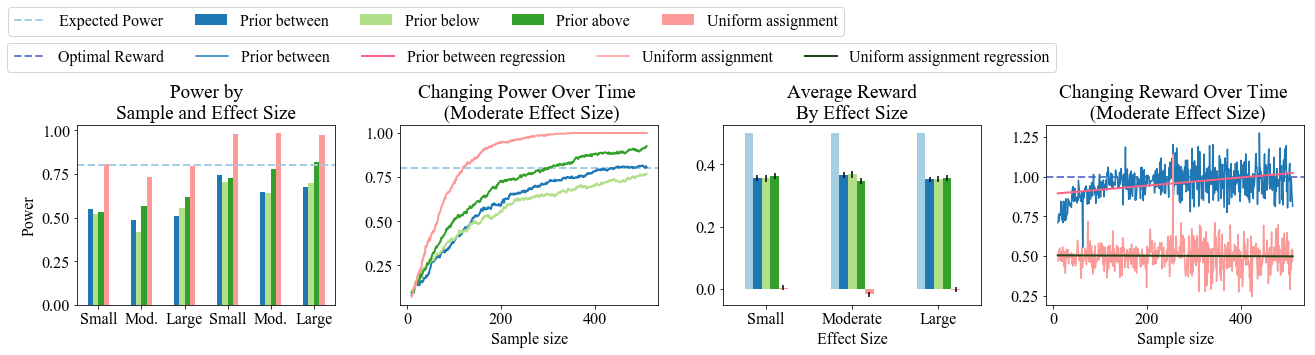

In [22]:
# Graph for poster version - has average power and reward by effect size and changing reward over time for normal rewards
figure = plt.figure(figsize = (22, 4))
legend_height = 1.7
legendLeft = 3

stdError = True
#power graphs
ax = figure.add_subplot(1, 4, 1)
# ax = figure.add_subplot(1, len(effectSizeN) + 1, 3)
# if i == 0:
#     ax.set_ylabel("Power")
import pickle
normal_power = pd.read_pickle(date_prefix+'NormalPower.pkl')
normal_power_mid_es = pd.read_pickle(date_prefix+'NormalPowerMidES.pkl')
normal_power_condensed_df = make_combined_df_power_condensed(normal_power, effectSizeN)
setLegend = True
# avg_power_normal = normal_power[i]
plot_power_bar_condensed(normal_power_condensed_df, ["x_spacing"], list(mean_names_lst), effectSizeN[0], ax, setLegend, \
               "Power by\nSample and Effect Size", \
               legend_anchor=(legendLeft, legend_height), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
setLegend = False
    
# Line graph for power per step for mid effect size
ax = figure.add_subplot(1, len(effectSizeN) + 1, 2)
ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in normal_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample size')
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

# Reward graphs
# Bar for Normal Reward 
ax = figure.add_subplot(1, 4, 3)
plot_avg_reward_gain_at_m(NORMAL, ax, hasLegend=False, stdError=stdError)

# Line for Normal Reward 
mid_es_N = effectSizeN[len(effectSizeN) // 2]
ax = figure.add_subplot(1, 4, 4)
# avg_rewards_per_trial_normal = get_avg_col_per_trial_dfsByTrial(mid_es_N, NORMAL, "total_reward", False)
# import pickle
# with open(date_prefix+'AvgRewardsPerTrialNormal.pkl', 'wb') as f:
#     pickle.dump(avg_rewards_per_trial_normal, f)
avg_rewards_per_trial_normal = pd.read_pickle(date_prefix+'AvgRewardsPerTrialNormal.pkl')

subplot_line(avg_rewards_per_trial_normal, mid_es_N, "Normal", ax, True, title="Changing Reward Over Time \n (Moderate Effect Size)", \
            legend_anchor=(legendLeft-2.93, legend_height - .2), hline_value=1.0, hline_label="Optimal Reward", color=colors_line_reward)

# Set super title for all subgraphs
plt.subplots_adjust(top=.75)
plt.subplots_adjust(wspace=.25)
if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
figure.savefig(outdir+date_prefix+'AvgPowerAndRewardsNormal.pdf', bbox_inches='tight')
print(outdir+date_prefix+'AvgPowerAndRewardsNormal.pdf')

### Combine Plots

In [17]:
def plot_avg_reward_gain_at_m(reward_type, ax, ylabel="", hasLegend=True, legend_anchor=(0.55, 1.55), stdError=False):
    df = pd.DataFrame(dtype=float)
    import pickle
    if reward_type == BINARY:
        effectSize = effectSizeB
        df = pd.read_pickle(date_prefix+'BinaryRewardBarDF.pkl')

    elif reward_type == NORMAL:
        effectSize = effectSizeN
        df = pd.read_pickle(date_prefix_normal+'NormalRewardBarDF.pkl')
        df["Optimal Reward"] = 0.5

#     for i in range(len(effectSize)):
#         es = effectSize[i]
#         df_m = get_avg_col_per_step_dfs(es, reward_type, "total_reward", stdError).iloc[1:2]
#         df_m["effect_size"] = es
#         df_m["Optimal Reward"] = get_better_arm(effectSize[i], reward_type)
#         df_m["or_std"] = pd.Series()

#         df = pd.concat([df, df_m])
#     df = df.reset_index().set_index('effect_size')
#     import pickle
#     if reward_type == BINARY:
#         with open(date_prefix+'BinaryRewardBarDF.pkl', 'wb') as f:
#             pickle.dump(df, f)
#     elif reward_type == NORMAL:
#         with open(date_prefix+'NormalRewardBarDF.pkl', 'wb') as f:
#             pickle.dump(df, f)
    
    m = df[["Optimal Reward"]+list(mean_names_lst)]
    std = df[list(std_names_lst)+['or_std']]
    std.columns = list(mean_names_lst)+['Optimal Reward']
    m.plot.bar(ax=ax, yerr=std, rot=0, color=colors)

    ax.set_xlabel('Effect size')
    xticks = list(effectSize_label)
    xticks[1] = 'Moderate'
    ax.set_xticklabels(xticks)
    ax.set_ylabel(ylabel)

    if hasLegend:
        leg  = ax.legend(ncol=5, bbox_to_anchor=legend_anchor, fontsize=16)
        leg.get_texts()[len(leg.get_texts()) - 1].set_text('Uniform assignment')
    else:
        ax.legend_.remove()

    if reward_type == BINARY:
        ax.set_title("Average Reward\nBy Effect Size")
    elif reward_type == NORMAL:
        ax.set_title("Average Reward\nBy Effect Size")
    return ax

In [25]:
import pickle
dfs_reward_binary = pd.read_pickle(date_prefix+'RewardBinary.pkl')
dfs_reward_normal = pd.read_pickle(date_prefix+'RewardNormal.pkl')
dfs_reward_binary

[           Prior between  Prior below  Prior above  Uniform Sampling  \
 num_steps                                                              
 393             0.530244     0.528687     0.527247          0.500738   
 785             0.536069     0.535363     0.534718          0.499490   
 1570            0.541608     0.541489     0.541332          0.499873   
 3140            0.544989     0.543633     0.544874          0.500031   
 
            Prior between std  Prior below std  Prior above std  \
 num_steps                                                        
 393                 0.001467         0.001517         0.001366   
 785                 0.001045         0.001043         0.000989   
 1570                0.000689         0.000741         0.000652   
 3140                0.000437         0.000510         0.000431   
 
            Uniform Sampling std  
 num_steps                        
 393                    0.001134  
 785                    0.000819  
 1570           

# Power

In [14]:
def get_power_per_trial_dfs(effect_size, reward_type):
    effect_size = str(effect_size)
    if reward_type == BINARY:
        df_bandit = pd.read_pickle(bb_prefix+effect_size+bb_infix+effect_size+byTrial_suffix)
        df_uniform = pd.read_pickle(bu_prefix+effect_size+bu_infix+effect_size+byTrial_suffix)
    elif reward_type == NORMAL:
        df_bandit = pd.read_pickle(ng_prefix+effect_size+ng_infix+effect_size+byTrial_suffix)
        df_uniform = pd.read_pickle(nu_prefix+effect_size+nu_infix+effect_size+byTrial_suffix)
        
    # Bandit sampling
    bandit_ppt = df_bandit[['trial','power']]
    # Uniform sampling
    uniform_ppt = df_uniform[['trial','power']]

    power_per_trial = pd.merge(bandit_ppt, uniform_ppt, how='outer', on=['trial'])\
        .set_index('trial')

    return power_per_trial

### Binary Reward

In [15]:
def get_power_by_steps(dfs_by_trial, columns, alpha = 0.05):
    '''
    df_by_trial is a data frame with information about each run,
    as calculated by calculate_by_trial_statistics_from_sims.
    This function returns the continuous evaluation of power at every step until 4m steps,
    and the power snapshot at step 0.5m, m, 2m and 4m for all effect sizes.
    Power is calculated as what proportion of the p-values were below alpha at that point.
    '''
    unique_sample_sizes = dfs_by_trial[0].num_steps.unique()

    power_df = pd.DataFrame(columns=columns)
    power_all_steps = []
    for i in range(len(unique_sample_sizes)):
        cur_n = unique_sample_sizes[i]
        power_df.loc[i,columns[0]] = cur_n
        # Add bandit and uniform sampling lines 
        j = 1
        for df in dfs_by_trial:
            cur_df = df[df['num_steps'] == cur_n]
            statistic_list = []
            for trial in range(10, cur_n):
                avg_stat = np.sum(cur_df[cur_df['trial'] == trial]['pvalue'] < alpha) \
                            / len(cur_df[cur_df['trial'] == trial])
                statistic_list.append(avg_stat)
            
            if cur_n == unique_sample_sizes[-1]:
                power_all_steps.append(statistic_list[:])
            
            power_df.iloc[i, j] = statistic_list[-1]
            j+=1
    return power_all_steps, power_df

In [16]:
def plot_power_bar(df, x_col, y_col, effect_size, ax, setLegend, title, legend_anchor=(0.7, 1.5), ylabel="", \
                   hline_value=None, hline_label=None, color=colors):
    x = df[x_col]
    y = df[y_col]

    y.plot.bar(ax=ax, rot=0, color=color[1:])
    plt.xlabel("Step, m="+str(x.iloc[1, 0]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    
    legend = y_col
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)
        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

In [47]:
def plot_power_bar_condensed(df, x_col, y_col, effect_size, ax, setLegend, title, legend_anchor=(0.7, 1.5), ylabel="", \
                   hline_value=None, hline_label=None, color=colors):
    x = df[x_col]
    y = df[y_col]
    print('x_col',x_col)
    print('y',y)
    df.plot.bar(y=y_col, ax=ax, rot=0, color=color[1:])
#     plt.xlabel("Step, m="+str(x.iloc[1, 0]))
    plt.xlabel('')
    ax.set_xticklabels(['Small', 'Mod.', 'Large','Small', 'Mod.', 'Large'])
    
    legend = y_col
    
    if hline_value!=None:
        ax.axhline(hline_value,0,1, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        leg = ax.legend(legend, ncol=len(legend), bbox_to_anchor=legend_anchor)
        leg.get_texts()[len(leg.get_texts()) - 1].set_text('Uniform assignment')

        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

In [68]:
binary_power = []
binary_power_mid_es = []
for i in range(len(effectSizeB)):
    effect_size = str(effectSizeB[i])
    df_lst = []
    prefix_lst = b_prefix_lst
    infix_lst = b_infix_lst
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+effect_size+infix+effect_size+byTrial_suffix)
        df_lst.append(df)
        
    power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"] + list(mean_names_lst))
    binary_power.append(power_df)
    if effect_size == str(effectSizeB[len(effectSizeB) // 2]):
        binary_power_mid_es = power_all_steps
        
import pickle

with open(date_prefix+'BinaryPower.pkl', 'wb') as f:
    pickle.dump(binary_power, f)
    
with open(date_prefix+'BinaryPowerMidES.pkl', 'wb') as f:
    pickle.dump(binary_power_mid_es, f)  

FileNotFoundError: [Errno 2] No such file or directory: 'bb0.1BB0.1DfByTrial.pkl'

### Load data from pickle

In [45]:
import pickle
binary_power = pd.read_pickle(date_prefix+'BinaryPower.pkl')
binary_power_mid_es = pd.read_pickle(date_prefix+'BinaryPowerMidES.pkl')
normal_power = pd.read_pickle(date_prefix_normal+'NormalPower.pkl')
normal_power_mid_es = pd.read_pickle(date_prefix_normal+'NormalPowerMidES.pkl')
# with open(date_prefix+'BinaryPower.pkl', 'rb') as f:
#     binary_power = pd.read_pickle(date_prefix+'BinaryPower.pkl')#pickle.load(f)
    
# with open(date_prefix+'BinaryPowerMidES.pkl', 'rb') as f:
#     binary_power_mid_es = pickle.load(f) 

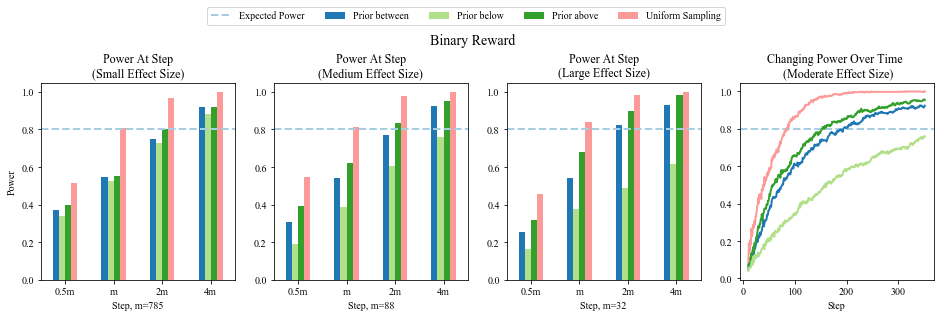

In [107]:
figure = plt.figure(figsize = (16, 4))
setLegend = True
# Bar graph for power at step m
for i in range(len(effectSizeB)):
    ax = figure.add_subplot(1, len(effectSizeB) + 1, i + 1)

    avg_power_binary = binary_power[i]
    plot_power_bar(avg_power_binary, ["num_steps"], list(mean_names_lst), effectSizeB[i], ax, setLegend, \
                   "Power At Step\n("+effectSize_label[i]+" Effect Size)",\
                   legend_anchor=(3.55, 1.41), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
    setLegend = False
    
# Line graph for power per step for mid effect size
ax = figure.add_subplot(1, len(effectSizeB) + 1, i + 2)
ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in binary_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Step')
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.81)
figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepBinary.pdf', bbox_inches='tight')

In [43]:
def make_combined_df_power_condensed(power_list, effectSizes):
    new_df = pd.DataFrame(columns=power_list[0].columns)
    for i in range(len(effectSizes)):
        new_df = new_df.append(power_list[i][1:2],ignore_index=True)

    for i in range(len(effectSizes)):
        new_df = new_df.append(power_list[i][2:3],ignore_index=True)
    new_df['x_spacing'] = list(range(len(effectSizes))) + [num+len(effectSizes)+ 4 for num in range(len(effectSizeB))]
    return new_df

x_col ['x_spacing']
y   Prior between Prior below Prior above Uniform Sampling
0         0.546       0.528       0.554             0.81
1         0.544       0.386       0.622            0.812
2         0.542       0.376        0.68            0.838
3         0.748        0.73       0.802            0.966
4          0.77       0.608       0.834            0.978
5         0.822       0.488       0.896            0.982
x_col ['x_spacing']
y   Prior between Prior below Prior above Uniform Sampling
0         0.504       0.534       0.554            0.802
1         0.478       0.436       0.532            0.802
2         0.474        0.44       0.632            0.802
3         0.732        0.71       0.744            0.988
4         0.646       0.622        0.75             0.99
5         0.682       0.578       0.762            0.976


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


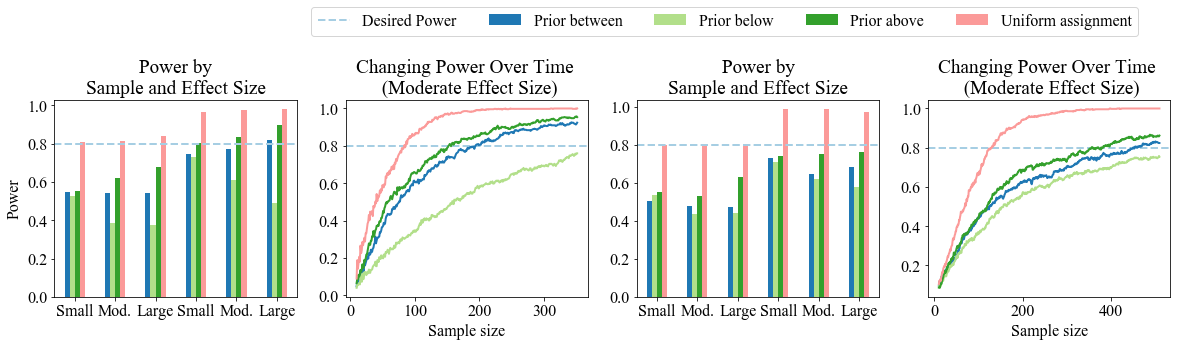

In [25]:
figure = plt.figure(figsize = (20,4))
setLegend = True
binary_power_condensed_df = make_combined_df_power_condensed(binary_power, effectSizeB)

# Bar graph for power at step m
# for i in range(len(effectSizeB)):
ax = figure.add_subplot(1, len(effectSizeB) + 1, 1)

# print('new_df',new_df)
# print('avg_power_binary',avg_power_binary)

plot_power_bar_condensed(binary_power_condensed_df, ["x_spacing"], list(mean_names_lst), effectSizeB[0], ax, setLegend, \
               "Power by\nSample and Effect Size",\
               legend_anchor=(4.5, 1.51), ylabel="Power", hline_value=0.8, hline_label="Desired Power")
setLegend = False
    
# Line graph for power per step for mid effect size
ax = figure.add_subplot(1, len(effectSizeB) + 1, 2)
ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in binary_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample size')
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

# figure.suptitle("Binary Reward",  fontsize=14)


ax = figure.add_subplot(1, len(effectSizeN) + 1, 3)
# if i == 0:
#     ax.set_ylabel("Power")
    
normal_power_condensed_df = make_combined_df_power_condensed(normal_power, effectSizeN)

# avg_power_normal = normal_power[i]
plot_power_bar_condensed(normal_power_condensed_df, ["x_spacing"], list(mean_names_lst), effectSizeN[0], ax, setLegend, \
               "Power by\nSample and Effect Size", \
               legend_anchor=(1, 1.65), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
setLegend = False
    
# Line graph for power per step for mid effect size
ax = figure.add_subplot(1, len(effectSizeN) + 1, 4)
ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in normal_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample size')
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

# figure.suptitle("Normal Reward",  fontsize=14)
plt.subplots_adjust(top=0.81)
figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepBinary.pdf', bbox_inches='tight')

x_col ['x_spacing']
y   Prior between Prior below Prior above Uniform Sampling
0         0.546       0.528       0.554             0.81
1         0.544       0.386       0.622            0.812
2         0.542       0.376        0.68            0.838
3         0.748        0.73       0.802            0.966
4          0.77       0.608       0.834            0.978
5         0.822       0.488       0.896            0.982
x_col ['x_spacing']
y   Prior between Prior below Prior above Uniform Sampling
0         0.504       0.534       0.554            0.802
1         0.478       0.436       0.532            0.802
2         0.474        0.44       0.632            0.802
3         0.732        0.71       0.744            0.988
4         0.646       0.622        0.75             0.99
5         0.682       0.578       0.762            0.976
graphs/190617MeasuredPowerPerStepBinary.pdf


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


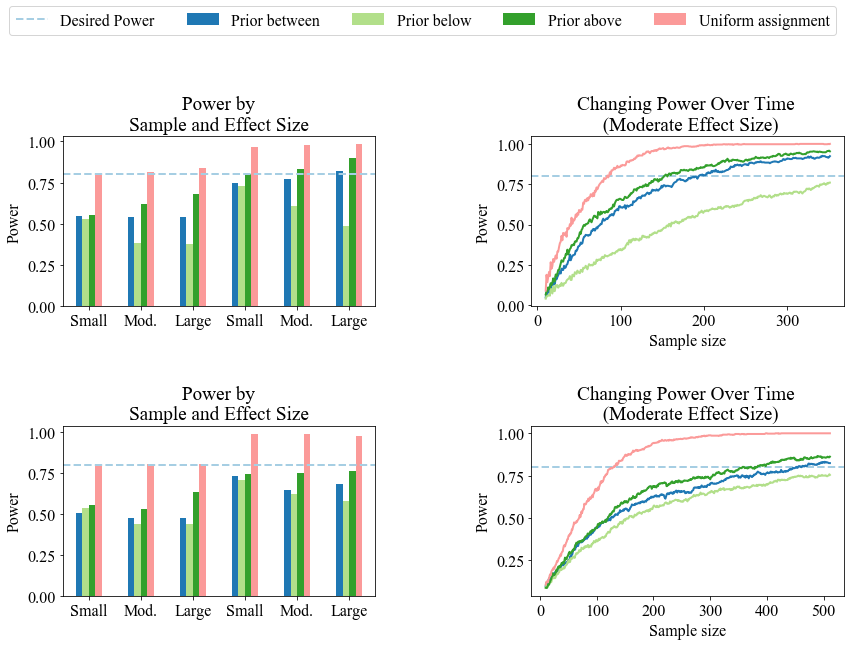

In [57]:
figure = plt.figure(figsize = (12,8))

# figure = plt.figure(figsize = (20,4))
setLegend = True
binary_power_condensed_df = make_combined_df_power_condensed(binary_power, effectSizeB)

# Bar graph for power at step m
# for i in range(len(effectSizeB)):
# ax = figure.add_subplot(1, len(effectSizeB) + 1, 1)
ax = figure.add_subplot(2, 2, 1)

# print('new_df',new_df)
# print('avg_power_binary',avg_power_binary)

plot_power_bar_condensed(binary_power_condensed_df, ["x_spacing"], list(mean_names_lst), effectSizeB[0], ax, setLegend, \
               "Power by\nSample and Effect Size",\
               legend_anchor=(2.5, 1.81), ylabel="Power", hline_value=0.8, hline_label="Desired Power")
setLegend = False
    
# Line graph for power per step for mid effect size
# ax = figure.add_subplot(1, len(effectSizeB) + 1, 2)
ax = figure.add_subplot(2, 2, 2)

ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in binary_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample size')
ax.set_ylabel("Power")
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

# figure.suptitle("Binary Reward",  fontsize=14)


# ax = figure.add_subplot(1, len(effectSizeN) + 1, 3)
ax = figure.add_subplot(2, 2, 3)

# if i == 0:
#     ax.set_ylabel("Power")
    
normal_power_condensed_df = make_combined_df_power_condensed(normal_power, effectSizeN)

# avg_power_normal = normal_power[i]
plot_power_bar_condensed(normal_power_condensed_df, ["x_spacing"], list(mean_names_lst), effectSizeN[0], ax, setLegend, \
               "Power by\nSample and Effect Size", \
               legend_anchor=(0, 1.85), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
setLegend = False
ax.set_ylabel("Power")    
# Line graph for power per step for mid effect size
# ax = figure.add_subplot(1, len(effectSizeN) + 1, 4)
ax = figure.add_subplot(2, 2, 4)

ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in normal_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Sample size')
ax.set_ylabel("Power")
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

# figure.suptitle("Normal Reward",  fontsize=14)
# plt.subplots_adjust(top=0.81)
figure.tight_layout()
figure.subplots_adjust(wspace = .5, hspace = .7)
save_date_prefix = "190617"
figure.savefig(outdir_prefix+save_date_prefix+'MeasuredPowerPerStepBinary.pdf', bbox_inches='tight')
print(outdir_prefix+save_date_prefix+'MeasuredPowerPerStepBinary.pdf')

In [49]:
new_df = pd.DataFrame(columns=binary_power[0].columns)
for i in range(len(effectSizeB)):
    print(binary_power[i][1:2])
    new_df = new_df.append(binary_power[i][1:2],ignore_index=True)
new_df['index'] = new_df.index
new_df

  num_steps Prior between Prior below Prior above Uniform Sampling
1       785         0.546       0.528       0.554             0.81
  num_steps Prior between Prior below Prior above Uniform Sampling
1        88         0.544       0.386       0.622            0.812
  num_steps Prior between Prior below Prior above Uniform Sampling
1        32         0.542       0.376        0.68            0.838


,num_steps,Prior between,Prior below,Prior above,Uniform Sampling,index
0,785,0.546,0.528,0.554,0.81,0
1,88,0.544,0.386,0.622,0.812,1
2,32,0.542,0.376,0.68,0.838,2


### Normal Reward

In [25]:
normal_power = []
normal_power_mid_es = []
for i in range(len(effectSizeN)):
    effect_size = str(effectSizeN[i])
    df_lst = []
    prefix_lst = n_prefix_lst
    infix_lst = n_infix_lst
    for i in range(len(prefix_lst)):
        prefix = prefix_lst[i]
        infix = infix_lst[i]
        df = pd.read_pickle(prefix+effect_size+infix+effect_size+byTrial_suffix)
        df_lst.append(df)
        
    power_all_steps, power_df = get_power_by_steps(df_lst, ["num_steps"]+list(mean_names_lst))
    normal_power.append(power_df)
    if effect_size == str(effectSizeN[len(effectSizeN) // 2]):
        normal_power_mid_es = power_all_steps
        
import pickle

with open(date_prefix+'NormalPower.pkl', 'wb') as f:
    pickle.dump(normal_power, f)
    
with open(date_prefix+'NormalPowerMidES.pkl', 'wb') as f:
    pickle.dump(normal_power_mid_es, f)  

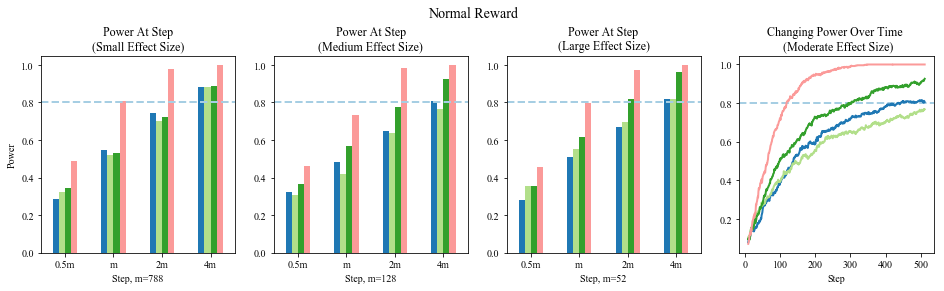

In [26]:
figure = plt.figure(figsize = (16, 4))
setLegend = False
# Bar graph for power at step m
for i in range(len(effectSizeN)):
    ax = figure.add_subplot(1, len(effectSizeN) + 1, i + 1)
    if i == 0:
        ax.set_ylabel("Power")
    avg_power_normal = normal_power[i]
    plot_power_bar(avg_power_normal, ["num_steps"], list(mean_names_lst), effectSizeN[i], ax, setLegend, \
                   "Power At Step\n("+effectSize_label[i]+" Effect Size)", \
                   legend_anchor=(0.6, 1.65), ylabel="Power", hline_value=0.8, hline_label="Expected Power")
    setLegend = False
    
# Line graph for power per step for mid effect size
ax = figure.add_subplot(1, len(effectSizeN) + 1, i + 2)
ax.axhline(0.8, color=colors[0], linestyle='dashed', linewidth=2)
i = 1
for p in normal_power_mid_es:
    x = range(10, len(p)+10)
    ax.plot(x, p, lw=2, color=colors[i])
    i+=1
ax.set_xlabel('Step')
plt.title("Changing Power Over Time \n (Moderate Effect Size)")

figure.suptitle("Normal Reward",  fontsize=14)
plt.subplots_adjust(top=0.81)
figure.savefig(outdir_prefix+date_prefix+'MeasuredPowerPerStepNormal.pdf', bbox_inches='tight')

# Average Measured Effect Size

In [9]:
def subplot_avg(df, effect_size, ax, setLegend, title, \
                ylabel="", hline_value=None, hline_label=None, setErrorBar=True, color=colors):
    means = df[list(mean_names_lst)]
    stds = df[list(std_names_lst)]
    stds.columns = list(mean_names_lst)
    
    if setErrorBar:
        means.plot.bar(ax=ax, yerr=stds, rot=0, color=color[1:])
    else:
        means.plot.bar(ax=ax, rot=0, color=color[1:])

    plt.xlabel("Step, m="+str(df.index[1]))
    ax.set_xticklabels(['0.5m', 'm', '2m', '4m'])
    
    legend = list(mean_names_lst)
    
    if hline_value!=None:
        ax.axhline(hline_value, color=color[0], linestyle='dashed', linewidth=2)
        legend.insert(0, hline_label)

    plt.title(title)
    
    if setLegend:
        ax.legend(legend, ncol=len(legend), bbox_to_anchor=(2.7, 1.35))
        ax.set_ylabel(ylabel)
    else:
        ax.legend_.remove()

### Binary Reward

In [ ]:
meas_es_binary = []
for i in range(len(effectSizeB)):
    avg_act_es_binary = get_avg_col_per_num_steps_dfs(effectSizeB[i], BINARY, "actual_es", stdError=stdError)
    meas_es_binary.append(avg_act_es_binary)
    
meas_es_normal = []
for i in range(len(effectSizeN)):
    avg_act_es_normal = get_avg_col_per_num_steps_dfs(effectSizeN[i], "N", "actual_es", stdError=stdError)
    meas_es_normal.append(avg_act_es_normal)
import pickle

with open(date_prefix+'MeasuredESBinary.pkl', 'wb') as f:
    pickle.dump(meas_es_binary, f)
    
with open(date_prefix+'MeasuredESNormal.pkl', 'wb') as f:
    pickle.dump(meas_es_normal, f)  

In [12]:
import pickle
meas_es_binary = pd.read_pickle(date_prefix+'MeasuredESBinary.pkl')
meas_es_normal = pd.read_pickle(date_prefix+'MeasuredESNormal.pkl')


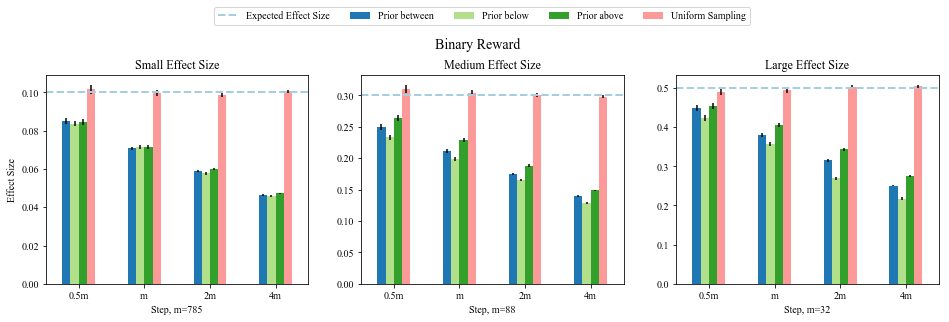

In [13]:
figure = plt.figure(figsize = (16, 4))
setLegend = True
stdError = True

# Plot subgraphs
for i in range(len(effectSizeB)):
    ax = figure.add_subplot(1, len(effectSizeB), i + 1)
    avg_act_es_binary = meas_es_binary[i]#get_avg_col_per_num_steps_dfs(effectSizeB[i], BINARY, "actual_es", stdError=stdError)
    subplot_avg(avg_act_es_binary, effectSizeB[i], ax, setLegend, effectSize_label[i]+" Effect Size", \
                ylabel="Effect Size", hline_value=effectSizeB[i], hline_label="Expected Effect Size", setErrorBar=True)
    setLegend = False
    
# Set super title for all subgraphs
figure.suptitle("Binary Reward",  fontsize=14)
plt.subplots_adjust(top=0.85)

if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
    
figure.savefig(outdir+date_prefix+'AvgMeasuredESBinary.pdf', bbox_inches='tight')

### Normal Rewards

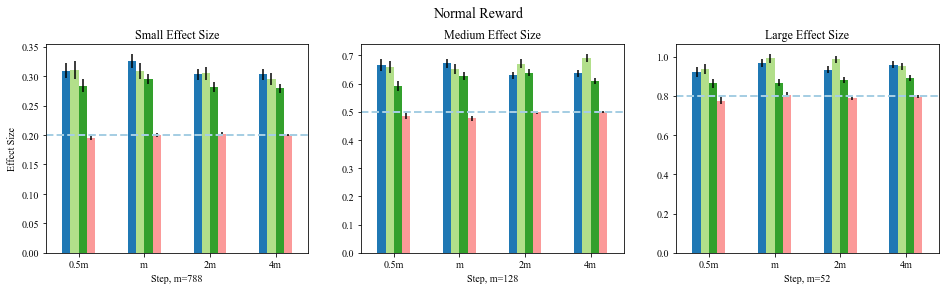

In [14]:
figure = plt.figure(figsize = (16, 4))
setLegend = False
stdError = True

# Plot subgraphs
for i in range(len(effectSizeN)):
    ax = figure.add_subplot(1, len(effectSizeN), i + 1)
    if i == 0:
        ax.set_ylabel("Effect Size")
    avg_act_es_normal = meas_es_normal[i]#get_avg_col_per_num_steps_dfs(effectSizeN[i], "N", "actual_es", stdError=stdError)
    subplot_avg(avg_act_es_normal, effectSizeN[i], ax, setLegend, effectSize_label[i]+" Effect Size", \
                ylabel="Effect Size", hline_value=effectSizeN[i], hline_label="Expected Effect Size", setErrorBar=True)
    setLegend = False
    
# Set super title for all subgraphs
figure.suptitle("Normal Reward",  fontsize=14)
plt.subplots_adjust(top=0.85)

if (stdError):
    outdir = outdir_prefix_std_error
else:
    outdir = outdir_prefix
    
figure.savefig(outdir+date_prefix+'AvgMeasuredESNormal.pdf', bbox_inches='tight')

In [15]:
meas_es_normal

[           Prior between  Prior below  Prior above  Uniform Sampling  \
 num_steps                                                              
 394             0.309122     0.311011     0.283763          0.195392   
 788             0.325750     0.309543     0.295295          0.200564   
 1576            0.303324     0.304664     0.281331          0.202400   
 3152            0.303038     0.294438     0.279243          0.200599   
 
            Prior between std  Prior below std  Prior above std  \
 num_steps                                                        
 394                 0.012525         0.015290         0.011077   
 788                 0.011994         0.013514         0.009158   
 1576                0.009607         0.011168         0.008293   
 3152                0.009626         0.010272         0.008089   
 
            Uniform Sampling std  
 num_steps                        
 394                    0.004359  
 788                    0.003319  
 1576           